In [21]:
import os
import sys
import pandas as pd
import numpy as np
import comtypes.client
import ctypes

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [22]:
from utils import * 

In [23]:
g = 9.8067  # m/s²
Norma = "NSR-10"
Suelo = "E"
GrupoUso = "I"
CoefImportancia = coef_import(GrupoUso)
Aa = 0.25
Av = 0.20
R = 7
H_total = 8.1 # m

In [24]:
if Norma == "NSR-10":    
    df_Fa = pd.read_excel("Tables NSR 10.xlsx", sheet_name="Tabla A.2.4-3_Fa", index_col=0)
    df_Fv = pd.read_excel("Tables NSR 10.xlsx", sheet_name="Tabla A.2.4-4_Fv", index_col=0)

    Fa = df_Fa.loc[Suelo, Aa]
    Fv = df_Fv.loc[Suelo, Av]

    T0 = 0.10 * (Av*Fv)/(Aa*Fa)
    Tc = 0.48 * (Av*Fv)/(Aa*Fa)
    Tl = 2.4*Fv

elif Norma == "MZSC-14":
    """
    Impementar lectura de tablas para MZSC-14
    """

    #df_Fa = pd.read_excel("Tables NSR 10.xlsx", sheet_name="MZSC-Espectro T corto", index_col=0)
    #df_Fv = pd.read_excel("Tables NSR 10.xlsx", sheet_name="MZSC-Espectro T largo", index_col=0)
    
    pass

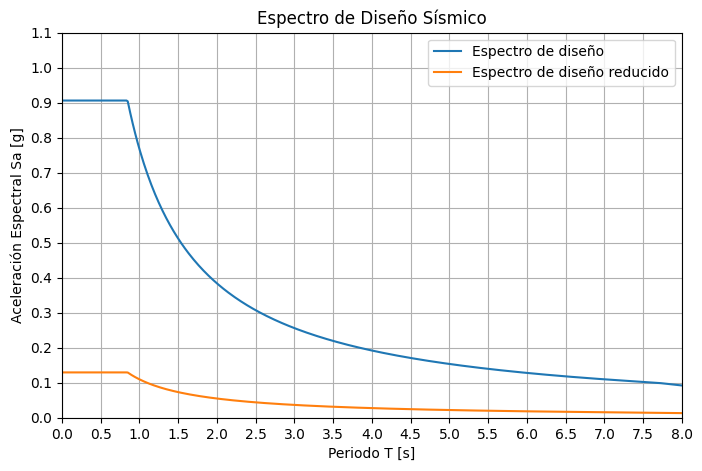

In [25]:
plt.figure(figsize=(8, 5))

T, Sa = plot_espectro_nsr10(Aa, Av, Fa, Fv, T0, Tc, Tl, CoefImportancia, 1, tipo_espectro='diseño')
T, Sa_diseno = plot_espectro_nsr10(Aa, Av, Fa, Fv, T0, Tc, Tl, CoefImportancia, R, tipo_espectro='diseño reducido')

plt.xlabel('Periodo T [s]')
plt.ylabel('Aceleración Espectral Sa [g]')
plt.title('Espectro de Diseño Sísmico')
plt.grid(True)
plt.legend()
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.xlim(0, 8)
plt.ylim(0, 1.1)
plt.show()

T_Sa_df = pd.DataFrame({'T': T, 'Sa': Sa, 'Sa_diseno': Sa_diseno})

In [26]:
Ta_df = pd.read_excel("Tables NSR 10.xlsx", sheet_name="Sistema estructural", index_col=0)

Sistema_estructural = "Pórticos de Concreto Resistente a Momento"
Ct = Ta_df.loc[Sistema_estructural, 'Ct']
a = Ta_df.loc[Sistema_estructural, 'a']

Ta = float(Ct * (H_total ** a))
Cu = max(1.2, 1.75-1.2*Av*Fv)
CuTa = Cu * Ta

# Model

In [27]:
# Directorio y nombre del modelo ETABS
ModelName = "Test.edb"

spectrum_name = "Espectro Prueba"

In [28]:
# Basic options to control ETABS instance

AttachToInstance = True  # False si el programa no está abierto

# Con respecto a qué instancia de ETABS usar
SpecifyPath = False
ProgramPath = R"C:\Program Files\Computers and Structures\ETABS 22\ETABS.exe"


APIPath = R"C:\Users\juanj\Documents\0. CODING\4_ETABS_API\Model"
if not os.path.exists(APIPath):
    try:
        os.makedirs(APIPath)
    except OSError:
        pass

ModelPath = APIPath + os.sep + ModelName

# create API helper object
helper = comtypes.client.CreateObject("ETABSv1.Helper")
helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)

if AttachToInstance:
    # attach to a running instance of ETABS
    try:
        # get the active ETABS object
        myETABSObject = helper.GetObject("CSI.ETABS.API.ETABSObject")
    except (OSError, comtypes.COMError):
        print("No running instance of the program found or failed to attach.")
        sys.exit(-1)
else:
    if SpecifyPath:
        try:
            #'create an instance of the ETABS object from the specified path
            myETABSObject = helper.CreateObject(ProgramPath)
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program from " + ProgramPath)
            sys.exit(-1)
    else:
        try:
            # create an instance of the ETABS object from the latest installed ETABS
            myETABSObject = helper.CreateObjectProgID("CSI.ETABS.API.ETABSObject")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program.")
            sys.exit(-1)

    # start ETABS application
    myETABSObject.ApplicationStart()

# create SapModel object
SapModel = myETABSObject.SapModel

#initialize model
kN_m_C = 6  # Units kN, m, C
kgf_m_C = 8 # Units kgf, m, C
Ton_m_C = 12 # Units Ton, m, C
ret = SapModel.SetPresentUnits(kN_m_C)


# Set seismic cases to default values
ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SX",
    1,
    ('U1',),
    (spectrum_name,),
    (g,),  # SF
    ('Global',),  # CSys
    (0.0,),  # Ang
)

ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SY",
    1,
    ('U2',),
    (spectrum_name,),
    (g,),  # SF
    ('Global',),  # CSys
    (0.0,),  # Ang
)

In [29]:
def save_and_unlock():
    ret = SapModel.SelectObj.All()
    ret = SapModel.File.Save(ModelPath)
    ret = SapModel.SetModelIsLocked(False)
    ret = SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()

def save_and_run():
    ret = SapModel.SelectObj.All()
    ret = SapModel.File.Save(ModelPath)
    ret = SapModel.Analyze.RunAnalysis()
    ret = SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()

In [30]:
save_and_unlock()

ret = SapModel.Func.GetNameList()

if spectrum_name in ret[1]:
    print(f"El espectro '{spectrum_name}' ya existe.")

else:
    T_values = T_Sa_df['T'].values
    Sa_values = T_Sa_df['Sa_diseno'].values

    # Prepare data for ETABS
    periods, accelerations = zip(*sorted(zip(T_values, Sa_values)))

    db_tables = SapModel.DatabaseTables
    table_key = "Functions - Response Spectrum - User Defined"
    ret01 = db_tables.GetAllFieldsInTable(table_key)

    fields = ["Name", "Period", "Value", "DampingRatio"]

    # Create table data - each record is a complete row
    table_data = []
    for period, accel in zip(periods, accelerations):
        table_data.append([
            spectrum_name,      # Name
            str(period),        # Period sec
            str(accel),         # Value
            "0.05",             # Damping Ratio (5%)
        ])

    flattened_data = [item for row in table_data for item in row]

    ret02 = db_tables.SetTableForEditingArray( table_key, 1, fields, len(table_data), flattened_data)
    ret03 = db_tables.ApplyEditedTables(True)

El espectro 'Espectro Prueba' ya existe.


In [31]:
def extract_values(name):
    table = SapModel.DatabaseTables.GetTableForDisplayArray(name, GroupName="")
    df = pd.DataFrame(np.array_split(table[4], table[3]))
    df.columns = table[2] # Ajustar los nombres de las columnas
    return df

In [32]:
save_and_run()

In [33]:
# 1. Masa del modelo

table_mass = "Story Forces"
table_mass_df = extract_values(table_mass)
table_mass_df = table_mass_df[
    (table_mass_df["Location"] == "Bottom") & (table_mass_df["OutputCase"] == "MASA")
].reset_index(drop=True)

columns_to_drop = ["OutputCase", "CaseType", "StepType", "StepNumber", "Location", "VX", "VY", "T", "MX", "MY"]
table_mass_df = table_mass_df.drop(columns=columns_to_drop)

# Pisos del modelo
stories = table_mass_df["Story"].dropna().unique().tolist()
print("Pisos del modelo:", stories)

# Ensure P is numeric
table_mass_df["P"] = pd.to_numeric(table_mass_df["P"], errors="coerce")

# Calculate P_i as desired
table_mass_df["Masa_i"] = table_mass_df["P"].diff()
table_mass_df.loc[0, "Masa_i"] = table_mass_df.loc[0, "P"]

table_mass_df

Pisos del modelo: ['N+08.10', 'N+05.00']


,Story,StepLabel,P,Masa_i
0,N+08.10,None,3072.9181,3072.9181
1,N+05.00,None,6818.6868,3745.7687


In [34]:
# 2. Modal Participating Mass Ratios

table_periods = "Modal Participating Mass Ratios"
table_periods_df = extract_values(table_periods)
table_periods_df.head()

,Case,Mode,Period,UX,UY,UZ,SumUX,SumUY,SumUZ,RX,RY,RZ,SumRX,SumRY,SumRZ
0,Modal,1,0.429,1.377E-06,0.9205,2.555E-05,1.377E-06,0.9205,2.555E-05,0.0109,5.436E-07,0.0002,0.0109,5.436E-07,0.0002
1,Modal,2,0.375,0.9292,4.286E-06,1.708E-05,0.9292,0.9205,4.263E-05,2.33E-06,0.0047,0.011,0.0109,0.0047,0.0112
2,Modal,3,0.307,0.0102,0.0001,2.782E-06,0.9395,0.9207,4.541E-05,2.423E-05,0.0001,0.9152,0.0109,0.0048,0.9264
3,Modal,4,0.179,0.0002,0,0.0001,0.9396,0.9207,0.0002,0.0001,0.0218,2.176E-06,0.011,0.0266,0.9264
4,Modal,5,0.16,0.0007,0,0.0019,0.9403,0.9207,0.0021,0.0007,0.1264,7.388E-06,0.0117,0.153,0.9264


In [35]:
table_periods_df["SumUX"] = pd.to_numeric(table_periods_df["SumUX"], errors="coerce")
tx_row = table_periods_df.loc[table_periods_df["SumUX"] > 0.9].iloc[0]
tx = float(tx_row["Period"])

table_periods_df["SumUY"] = pd.to_numeric(table_periods_df["SumUY"], errors="coerce")
ty_row = table_periods_df.loc[table_periods_df["SumUY"] > 0.9].iloc[0]
ty = float(ty_row["Period"])

In [36]:
# 3. Fuerza Horizontal Equivalente
tx = min(tx, CuTa)
ty = min(ty, CuTa)

Sa_x = T_Sa_df.loc[T_Sa_df['T'] >= tx, 'Sa_diseno'].iloc[0]
Sa_y = T_Sa_df.loc[T_Sa_df['T'] >= ty, 'Sa_diseno'].iloc[0]

print(f'Sa_x = {Sa_x} g')
print(f'Sa_y = {Sa_y} g')

kx = k_value(tx)
ky = k_value(ty)

FHE_df = table_mass_df.copy().drop(columns=["P"])
FHE_df["Masa_acum_i"] = FHE_df["Masa_i"].cumsum()
FHE_df["h_i"] = [8.1, 5]
FHE_df["Masa_acum_i * h_i ^ k"] = FHE_df["Masa_acum_i"] * FHE_df["h_i"]**kx

Masa_total = FHE_df["Masa_i"].sum()
Masa_factor = FHE_df["Masa_acum_i * h_i ^ k"].sum()

FHE_df["Cv"] = FHE_df["Masa_acum_i * h_i ^ k"] / Masa_factor
Cv_total = FHE_df["Cv"].sum().round(3)

if Cv_total != 1:
    print("Revisar cálculos, masas y factores. Cv_total != 1")

Vb_X_FHE = Sa_x * Masa_total
Vb_Y_FHE = Sa_y * Masa_total

print(f'Vb_X_FHE = {Vb_X_FHE}')
print(f'Vb_Y_FHE = {Vb_Y_FHE}')

FHE_df

Sa_x = 0.90625 g
Sa_y = 0.90625 g
Vb_X_FHE = 6179.434912500001
Vb_Y_FHE = 6179.434912500001


,Story,StepLabel,Masa_i,Masa_acum_i,h_i,Masa_acum_i * h_i ^ k,Cv
0,N+08.10,None,3072.9181,3072.9181,8.1,24890.63661,0.421989
1,N+05.00,None,3745.7687,6818.6868,5.0,34093.43400,0.578011


In [37]:
coef_regularidad = 0.8
Vb_X_FHE *= coef_regularidad
print(f'Vb_X_FHE = {Vb_X_FHE}')
Vb_Y_FHE *= coef_regularidad
print(f'Vb_Y_FHE = {Vb_Y_FHE}')

Vb_X_FHE = 4943.547930000001
Vb_Y_FHE = 4943.547930000001


In [38]:
# Dynamic forces
table_base_reaction = "Base Reactions"
table_base_reaction_df = extract_values(table_base_reaction)

columns_to_drop = ["StepNumber", "CaseType", "StepLabel", "StepType", "MX", "MY", "MZ", "X", "Y", "Z"]
table_base_reaction_df = table_base_reaction_df.drop(columns=columns_to_drop)
table_base_reaction_df = table_base_reaction_df[(table_base_reaction_df["OutputCase"] == "SX") | (table_base_reaction_df["OutputCase"] == "SY")].reset_index(drop=True)
table_base_reaction_df

,OutputCase,FX,FY,FZ
0,SX,5535.6044,20.5765,27.2161
1,SY,20.5765,5482.6936,41.2421


In [39]:
Vb_X_din = float(table_base_reaction_df.loc[table_base_reaction_df["OutputCase"] == "SX", "FX"].iloc[0])
Vb_Y_din = float(table_base_reaction_df.loc[table_base_reaction_df["OutputCase"] == "SY", "FY"].iloc[0])

factor_ajuste_X = max(1, Vb_X_FHE / Vb_X_din)
factor_ajuste_Y = max(1, Vb_Y_FHE / Vb_Y_din)

print(f"Cortante basal FHE X: {Vb_X_FHE:.2f} kN, Cortante basal dinámico X: {Vb_X_din:.2f} kN, Factor de ajuste: {factor_ajuste_X:.2f}")
print(f"Cortante basal FHE Y: {Vb_Y_FHE:.2f} kN, Cortante basal dinámico Y: {Vb_Y_din:.2f} kN, Factor de ajuste: {factor_ajuste_Y:.2f}")

Cortante basal FHE X: 4943.55 kN, Cortante basal dinámico X: 5535.60 kN, Factor de ajuste: 1.00
Cortante basal FHE Y: 4943.55 kN, Cortante basal dinámico Y: 5482.69 kN, Factor de ajuste: 1.00


In [40]:
save_and_unlock()

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SX")
print(ret)

ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SX",
    1,
    ('U1',),
    (spectrum_name,),
    (g*factor_ajuste_X,),  # SF
    ('Global',),  # CSys
    (0.0,),  # Ang
)

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SX")
print(ret)

print("="*70)

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SY")
print(ret)

ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SY",
    1,
    ('U2',),
    (spectrum_name,),
    (g*factor_ajuste_Y,),  # SF
    ('Global',),  # CSys
    (0.0,),  # Ang
)

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SY")
print(ret)

print("="*70)

[1, ('U1',), ('Espectro Prueba',), (9.8067,), ('Global',), (0.0,), 0]
[1, ('U1',), ('Espectro Prueba',), (9.8067,), ('Global',), (0.0,), 0]
[1, ('U2',), ('Espectro Prueba',), (9.8067,), ('Global',), (0.0,), 0]
[1, ('U2',), ('Espectro Prueba',), (9.8067,), ('Global',), (0.0,), 0]


### Derivas

In [41]:
save_and_run()

In [52]:
ret = SapModel.SelectObj.Group("Columnas")

table_drifts = "Joint Drifts"
table_drifts_df = extract_values(table_drifts)
table_drifts_df = table_drifts_df[(table_drifts_df["OutputCase"] == "SX") | (table_drifts_df["OutputCase"] == "SY")].reset_index(drop=True)
table_drifts_df["Combinada"] = (pd.to_numeric(table_drifts_df["DriftX"], errors="coerce")**2 + 
                                pd.to_numeric(table_drifts_df["DriftY"], errors="coerce")**2)**0.5

ret = SapModel.SelectObj.ClearSelection()

table_drifts_df

,Story,Label,UniqueName,OutputCase,CaseType,StepType,StepNumber,StepLabel,DispX,DispY,DriftX,DriftY,Combinada
0,N+08.10,16,285,SX,LinRespSpec,Max,None,None,0.040763,0.004719,0.005234,0.000681,0.005278
1,N+08.10,16,285,SY,LinRespSpec,Max,None,None,0.000547,0.050175,5.2E-05,0.007206,0.007206
2,N+08.10,19,230,SX,LinRespSpec,Max,None,None,0.033777,0.004837,0.004412,0.00059,0.004451
3,N+08.10,19,230,SY,LinRespSpec,Max,None,None,0.000656,0.050074,7.3E-05,0.007186,0.007186
4,N+08.10,20,235,SX,LinRespSpec,Max,None,None,0.033735,0.000295,0.004336,6.5E-05,0.004336
5,N+08.10,20,235,SY,LinRespSpec,Max,None,None,0.000567,0.050785,5.4E-05,0.007253,0.007253
6,N+08.10,26,240,SX,LinRespSpec,Max,None,None,0.033776,0.004249,0.004498,0.000554,0.004532
7,N+08.10,26,240,SY,LinRespSpec,Max,None,None,0.000486,0.050923,4.8E-05,0.007176,0.007176
8,N+08.10,42,245,SX,LinRespSpec,Max,None,None,0.036227,0.004224,0.004417,0.000556,0.004452
9,N+08.10,42,245,SY,LinRespSpec,Max,None,None,0.000219,0.050935,2.8E-05,0.007252,0.007252


In [53]:
ret = SapModel.SelectObj.Group("Columnas esquinas")

table_drifts_irreg = "Joint Drifts"
table_drifts_irreg_df = extract_values(table_drifts_irreg)
table_drifts_irreg_df = table_drifts_irreg_df[(table_drifts_irreg_df["OutputCase"] == "SX") | (table_drifts_irreg_df["OutputCase"] == "SY")].reset_index(drop=True)
table_drifts_irreg_df

,Story,Label,UniqueName,OutputCase,CaseType,StepType,StepNumber,StepLabel,DispX,DispY,DriftX,DriftY
0,N+08.10,16,285,SX,LinRespSpec,Max,None,None,0.040763,0.004719,0.005234,0.000681
1,N+08.10,16,285,SY,LinRespSpec,Max,None,None,0.000547,0.050175,5.2E-05,0.007206
2,N+08.10,19,230,SX,LinRespSpec,Max,None,None,0.033777,0.004837,0.004412,0.00059
3,N+08.10,19,230,SY,LinRespSpec,Max,None,None,0.000656,0.050074,7.3E-05,0.007186
4,N+08.10,20,235,SX,LinRespSpec,Max,None,None,0.033735,0.000295,0.004336,6.5E-05
5,N+08.10,20,235,SY,LinRespSpec,Max,None,None,0.000567,0.050785,5.4E-05,0.007253
6,N+08.10,26,240,SX,LinRespSpec,Max,None,None,0.033776,0.004249,0.004498,0.000554
7,N+08.10,26,240,SY,LinRespSpec,Max,None,None,0.000486,0.050923,4.8E-05,0.007176
8,N+08.10,42,245,SX,LinRespSpec,Max,None,None,0.036227,0.004224,0.004417,0.000556
9,N+08.10,42,245,SY,LinRespSpec,Max,None,None,0.000219,0.050935,2.8E-05,0.007252


In [54]:
labels = table_drifts_irreg_df["Label"].dropna().unique().tolist()
print("Labels de columnas:", labels)

for storie in stories:
    pass

Labels de columnas: ['16', '19', '20', '26', '42', '43', '44', '45', '46', '47', '48', '49', '50', '90', '91']
